In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 모든 경고 메시지 무시
warnings.filterwarnings("ignore")

In [15]:
train = pd.read_csv("../data/raw/train.csv", encoding="UTF-8")
dev = pd.read_csv("../data/raw/dev.csv", encoding="UTF-8")
test = pd.read_csv("../data/raw/test.csv", encoding="UTF-8")

In [16]:
def plot_label_count(df, df_name):
    grouped_data = df.groupby("label")["id"].count()
    grouped_data.plot(kind="bar", color="skyblue")
    plt.title(f"{df_name} label Count")
    plt.xlabel("label")
    plt.ylabel("Count")
    plt.show()

In [17]:
def special_value_interpolation(df):
    # 0.5, 1.5, 2.5, 3.5, 4.5에 해당하는 값을 필터링
    target_values = [0.5, 1.5, 2.5, 3.5, 4.5]
    filtered_df = df[df["label"].isin(target_values)]

    # 각 값에 대해 절반은 +0.1, 절반은 -0.1
    def adjust_labels(group):
        n = len(group)
        # 절반으로 나눔
        half_n = n // 2
        # 첫 절반은 -0.1, 나머지는 +0.1
        group.iloc[:half_n] -= 0.1
        group.iloc[half_n:] += 0.1
        return group

    # 필터링된 값들에 대한 보정
    df.loc[df["label"].isin(target_values), "label"] = filtered_df.groupby("label")[
        "label"
    ].transform(adjust_labels)
    return df

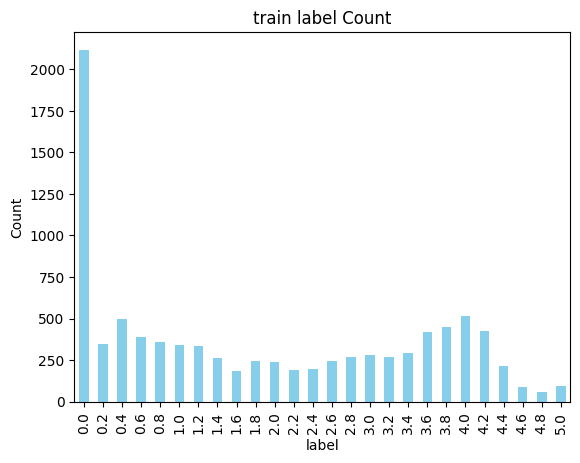

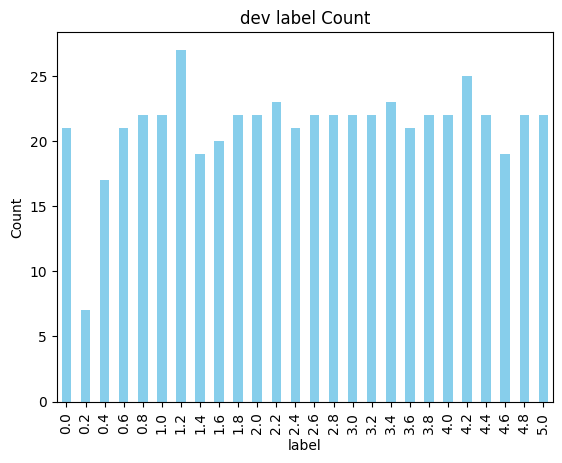

In [18]:
train = special_value_interpolation(train)
dev = special_value_interpolation(dev)
plot_label_count(train, "train")
plot_label_count(dev, "dev")

In [19]:
import pandas as pd


def random_sampling(df,SEED):
    # 0.0에서 5.0까지 0.2 간격으로 라벨을 설정
    labels = [round(x * 0.2, 1) for x in range(0, 26)]  # 0.0 ~ 5.0 까지

    sample_size_per_label = 20  # 각 라벨에서 추출할 개수
    sampled_df_list = []

    for label in labels:
        # 각 라벨에 해당하는 데이터 추출
        label_df = df[df["label"] == label]

        # 해당 라벨에서 샘플링할 수 있는 데이터가 충분하지 않으면 오류 방지
        if len(label_df) < sample_size_per_label:
            print(f"라벨 {label}에서 샘플링할 데이터가 부족합니다.")
            continue

        # 각 라벨에서 지정된 개수만큼 무작위로 샘플링 (random_state=42로 고정)
        sampled_label_df = label_df.sample(
            n=sample_size_per_label, random_state=SEED, replace=False
        )
        sampled_df_list.append(sampled_label_df)

    # 샘플링된 데이터를 하나의 DataFrame으로 합침
    final_sampled_df = pd.concat(sampled_df_list).reset_index(drop=True)

    # 남은 데이터를 하나의 DataFrame으로 합침 (추출되지 않은 데이터들)
    final_remaining_df = df.drop(final_sampled_df.index).reset_index(drop=True)

    # 추출한 510개의 데이터와 남은 데이터를 반환
    return final_sampled_df, final_remaining_df

In [20]:
new_dev, new_train = random_sampling(train,0)

In [21]:
new_train = pd.concat([new_train,dev])

In [22]:
def swap_over_zero_label(df):
    """sentence 1과 2를 교환한 데이터 추가"""
    df_swaped = df.rename(
        columns={"sentence_1": "sentence_2", "sentence_2": "sentence_1"}
    )
    df_filtered = df_swaped[df_swaped["label"] != 0.0]

    return pd.concat([df, df_filtered])

In [23]:
new_train = swap_over_zero_label(new_train)

In [24]:
new_train = new_train.sample(frac=1, random_state=0).reset_index(drop=True)
new_dev = new_dev.sample(frac=1, random_state=0).reset_index(drop=True)

In [25]:
new_train.to_csv("./split_v2_train.csv")
new_dev.to_csv("./split_v2_dev.csv")